<a href="https://colab.research.google.com/github/Riddars/BeerProject/blob/Update/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22BeerProject_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit
!pip install pycaret
!pip install lazypredict

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn import datasets
import networkx as nx
import lazypredict
from lazypredict.Supervised import LazyRegressor
import pickle
import tensorflow as tf

In [ ]:
data_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/BearProject/main/recipeData.csv', encoding='ISO-8859-1')

In [ ]:
data_df.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.05,1.01,5.48,17.65,...,1.04,70.00,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.00
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.08,1.02,8.16,60.65,...,1.07,70.00,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.00
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.06,1.02,5.91,59.25,...,NaN,70.00,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.06,1.02,5.80,54.48,...,NaN,70.00,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.06,1.01,6.48,17.84,...,1.05,72.00,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.00


**РАБОТА С ДАТАСЕТОМ**

In [ ]:
# Укажите список столбцов, которые вы хотите удалить
columns_to_drop = ['BeerID', 'URL', 'Style', 'UserId', 'Name', 'PrimaryTemp', 'PitchRate', 'MashThickness', 'PrimingMethod', 'PrimingAmount']

# Используйте метод drop для удаления столбцов
data_df.drop(columns=columns_to_drop, inplace=True)
# Удаление строк с пустыми значениями в столбце 'BoilGravity'
data_df.dropna(subset=['BoilGravity'], inplace=True)

In [ ]:
missing_values = data_df.isnull().sum()
print(missing_values)

StyleID        0
Size(L)        0
OG             0
FG             0
ABV            0
IBU            0
Color          0
BoilSize       0
BoilTime       0
BoilGravity    0
Efficiency     0
SugarScale     0
BrewMethod     0
dtype: int64


In [ ]:
data_df.head()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,SugarScale,BrewMethod
0,45,21.77,1.05,1.01,5.48,17.65,4.83,28.39,75,1.04,70.00,Specific Gravity,All Grain
1,85,20.82,1.08,1.02,8.16,60.65,15.64,24.61,60,1.07,70.00,Specific Gravity,All Grain
4,20,50.00,1.06,1.01,6.48,17.84,4.57,60.00,90,1.05,72.00,Specific Gravity,All Grain
5,10,24.61,1.05,1.01,5.58,40.12,8.00,29.34,70,1.05,79.00,Specific Gravity,All Grain
7,45,20.82,1.05,1.01,5.36,19.97,5.94,28.39,75,1.04,70.00,Specific Gravity,All Grain


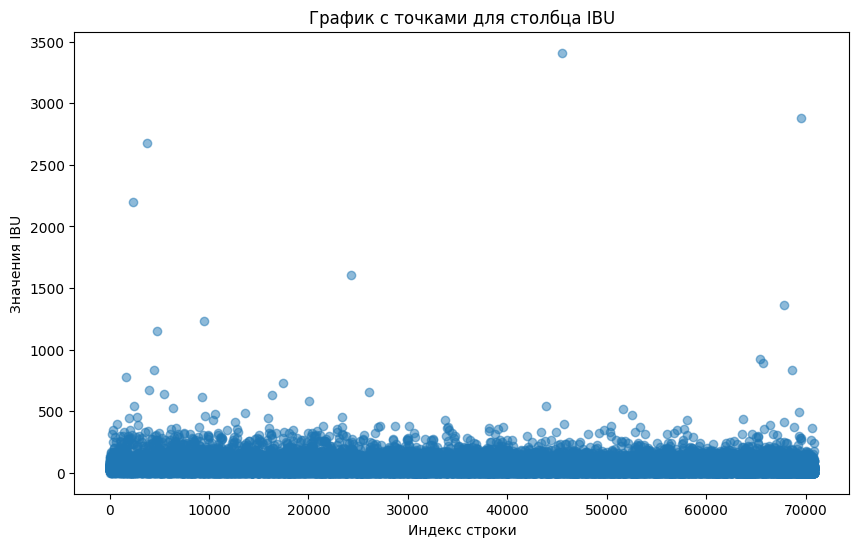

In [ ]:
# Замените 'IBU' на имя вашего столбца
ibu_values = data_df['IBU']

# Создайте график с точками
plt.figure(figsize=(10, 6))
plt.scatter(range(len(ibu_values)), ibu_values, alpha=0.5)
plt.xlabel('Индекс строки')
plt.ylabel('Значения IBU')
plt.title('График с точками для столбца IBU')
plt.show()

In [ ]:
mean_ibu = data_df['IBU'].mean()
variance_ibu = data_df['IBU'].var()

# Выведите результаты
print(f"Среднее значение IBU: {mean_ibu}")
print(f"Дисперсия IBU: {variance_ibu}")

Среднее значение IBU: 44.78287423628847
Дисперсия IBU: 1824.0585297490907


In [ ]:
data_df = data_df[data_df['IBU'] <= 200] # Удаляем все строки с аномальными значениями

In [ ]:
data_df = data_df[data_df['ABV'] <= 10]

In [ ]:
data_df = data_df[data_df['FG'] <= 5]

In [ ]:
data_df = data_df[data_df['Size(L)'] <= 2000]

In [ ]:
data_df = data_df[data_df['BoilSize'] <= 1000]

In [ ]:
data_df = data_df[data_df['BoilTime'] <= 125]

In [ ]:
data_df = data_df[data_df['BoilGravity'] <= 15]

In [ ]:
# Замените 'IBU' на имя вашего столбца
ibu_values = data_df['IBU']

# Определите интервалы
intervals = [0, 15, 20, float('inf')]  # Диапазоны: 0-100, 100-500, и выше 500

# Создайте гистограмму для подсчета частоты значений в каждом диапазоне
hist, bin_edges = np.histogram(ibu_values, bins=intervals)

# Выведите результаты
for i in range(len(hist)):
    if i == len(hist) - 1:
        print(f'Значения IBU выше {intervals[i]}: {hist[i]}')
    else:
        print(f'Значения IBU в диапазоне {intervals[i]}-{intervals[i + 1]}: {hist[i]}')


Значения IBU в диапазоне 0-15: 6705
Значения IBU в диапазоне 15-20: 4828
Значения IBU выше 20: 55724




---



(67257, 13)


<Axes: >

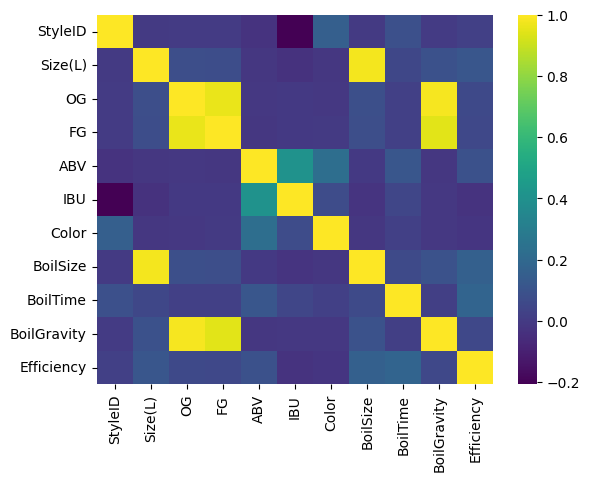

In [ ]:
# посмотрим корреляцию столбцов с числовыми значениями
print(data_df.shape)
sns.heatmap(data_df.corr(), cmap='viridis', yticklabels=True)

In [ ]:
#data_df.dropna(subset=['BoilGravity'], inplace=True)

**Encoding**


---




In [ ]:
le = LabelEncoder()
text_data_features = ['SugarScale', 'BrewMethod']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    data_df[i] = le.fit_transform(data_df[i])
    l3.append(list(data_df[i].unique())); l4.append(list(le.inverse_transform(data_df[i].unique())))
    print(i,' : ',data_df[i].unique(),' = ',le.inverse_transform(data_df[i].unique()))

Label Encoder Transformation


100%|██████████| 2/2 [00:00<00:00, 68.59it/s]

SugarScale  :  [1 0]  =  ['Specific Gravity' 'Plato']
BrewMethod  :  [0 3 1 2]  =  ['All Grain' 'extract' 'BIAB' 'Partial Mash']


**Нормализация числовых значений (кроме закодированых)**

---



In [ ]:
# Ваши данные и столбцы для нормализации
columns_to_normalize = ['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency']

# Получите минимальные и максимальные значения для каждого столбца до нормализации
min_values_before = data_df[columns_to_normalize].min()
max_values_before = data_df[columns_to_normalize].max()

print("Минимальные значения до нормализации:")
print(min_values_before)

print("Максимальные значения до нормализации:")
print(max_values_before)

Минимальные значения до нормализации:
Size(L)       1.00
OG            1.00
FG            0.43
ABV           0.00
IBU           0.00
Color         0.00
BoilSize      1.00
BoilTime      0.00
BoilGravity   0.00
Efficiency    0.00
dtype: float64
Максимальные значения до нормализации:
Size(L)       1400.00
OG              21.63
FG               4.99
ABV             10.00
IBU            200.00
Color           50.00
BoilSize      1000.00
BoilTime       125.00
BoilGravity     15.00
Efficiency     100.00
dtype: float64


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70871 entries, 0 to 73860
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StyleID      70871 non-null  int64  
 1   Size(L)      70871 non-null  float64
 2   OG           70871 non-null  float64
 3   FG           70871 non-null  float64
 4   ABV          70871 non-null  float64
 5   IBU          70871 non-null  float64
 6   Color        70871 non-null  float64
 7   BoilSize     70871 non-null  float64
 8   BoilTime     70871 non-null  int64  
 9   BoilGravity  70871 non-null  float64
 10  Efficiency   70871 non-null  float64
 11  SugarScale   70871 non-null  int64  
 12  BrewMethod   70871 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 7.6 MB


In [ ]:
nan_count = data_df.isna().sum()

# Выведите результат
print(nan_count)

StyleID        0
Size(L)        0
OG             0
FG             0
ABV            0
IBU            0
Color          0
BoilSize       0
BoilTime       0
BoilGravity    0
Efficiency     0
SugarScale     0
BrewMethod     0
dtype: int64


In [ ]:
#'IBU','FG', 'ABV', 'Color'

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на признаки (X) и целевые переменные (y)
X = data_df.drop(['IBU', 'FG', 'ABV', 'Color'], axis=1)  # Удалите 'IBU' из признаков
y = data_df[['IBU', 'FG', 'ABV', 'Color']]  # Используйте все целевые переменные

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели случайного леса с настраиваемыми параметрами
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    bootstrap=True,
    oob_score=False,
    criterion='squared_error'  # Используйте 'squared_error' для регрессии
)

# Обучение модели случайного леса на обучающем наборе данных
model.fit(X_train, y_train)

# Вывод характеристик после каждой итерации обучения
for i, estimator in enumerate(model.estimators_):
    print(f"Iteration {i + 1}:")

    # Предсказание на тестовом наборе данных
    y_pred = estimator.predict(X_test)

    # Оценка производительности модели на тестовом наборе данных
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print("-" * 40)

# После всех итераций, вы можете также оценить средние значения MSE и R-squared для всех моделей
mse_mean = mean_squared_error(y_test, model.predict(X_test))
r2_mean = r2_score(y_test, model.predict(X_test))
print("Mean of MSE:", mse_mean)
print("Mean of R-squared:", r2_mean)

Iteration 1:
Mean Squared Error: 228.33015032222988
R-squared: 0.5024594951512454
----------------------------------------
Iteration 2:
Mean Squared Error: 231.42283541820132
R-squared: 0.5025745012040432
----------------------------------------
Iteration 3:
Mean Squared Error: 233.05073974705346
R-squared: 0.4839879205765472
----------------------------------------
Iteration 4:
Mean Squared Error: 236.4860727011227
R-squared: 0.4660093590982849
----------------------------------------
Iteration 5:
Mean Squared Error: 228.82374492249656
R-squared: 0.5084972287846207
----------------------------------------
Iteration 6:
Mean Squared Error: 232.83086746763763
R-squared: 0.4477418101727976
----------------------------------------
Iteration 7:
Mean Squared Error: 228.3950291311212
R-squared: 0.5047025415251696
----------------------------------------
Iteration 8:
Mean Squared Error: 235.30292503181644
R-squared: 0.47005482673725335
----------------------------------------
Iteration 9:
Mean

[0]	validation_0-rmse:46.56438
[1]	validation_0-rmse:42.95520
[2]	validation_0-rmse:40.06629
[3]	validation_0-rmse:37.59159
[4]	validation_0-rmse:35.09303
[5]	validation_0-rmse:32.91636
[6]	validation_0-rmse:31.03195
[7]	validation_0-rmse:29.41933
[8]	validation_0-rmse:28.03159
[9]	validation_0-rmse:26.85628
[10]	validation_0-rmse:25.85313
[11]	validation_0-rmse:25.00978
[12]	validation_0-rmse:24.31111
[13]	validation_0-rmse:23.70773
[14]	validation_0-rmse:23.20540
[15]	validation_0-rmse:22.78749
[16]	validation_0-rmse:22.44071
[17]	validation_0-rmse:22.15262
[18]	validation_0-rmse:21.91819
[19]	validation_0-rmse:21.72558
[20]	validation_0-rmse:21.55498
[21]	validation_0-rmse:21.42842
[22]	validation_0-rmse:21.31138
[23]	validation_0-rmse:21.21310
[24]	validation_0-rmse:21.13532
[25]	validation_0-rmse:21.05979
[26]	validation_0-rmse:21.00682
[27]	validation_0-rmse:20.96662
[28]	validation_0-rmse:20.91711
[29]	validation_0-rmse:20.88163
[30]	validation_0-rmse:20.84403
[31]	validation_0-

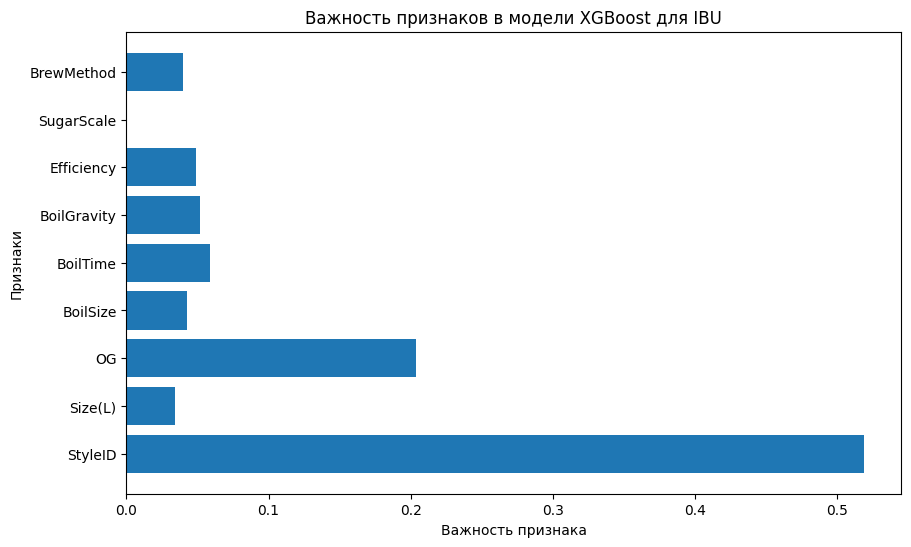

[0]	validation_0-rmse:0.56134
[1]	validation_0-rmse:0.50598
[2]	validation_0-rmse:0.45623
[3]	validation_0-rmse:0.41167
[4]	validation_0-rmse:0.37200
[5]	validation_0-rmse:0.33606
[6]	validation_0-rmse:0.30405
[7]	validation_0-rmse:0.27577
[8]	validation_0-rmse:0.25022
[9]	validation_0-rmse:0.22765
[10]	validation_0-rmse:0.20800
[11]	validation_0-rmse:0.19078
[12]	validation_0-rmse:0.17551
[13]	validation_0-rmse:0.16169
[14]	validation_0-rmse:0.14987
[15]	validation_0-rmse:0.13912
[16]	validation_0-rmse:0.13002
[17]	validation_0-rmse:0.12243
[18]	validation_0-rmse:0.11610
[19]	validation_0-rmse:0.11045
[20]	validation_0-rmse:0.10559
[21]	validation_0-rmse:0.10144
[22]	validation_0-rmse:0.09810
[23]	validation_0-rmse:0.09551
[24]	validation_0-rmse:0.09332
[25]	validation_0-rmse:0.09119
[26]	validation_0-rmse:0.08936
[27]	validation_0-rmse:0.08783
[28]	validation_0-rmse:0.08668
[29]	validation_0-rmse:0.08601
[30]	validation_0-rmse:0.08555
[31]	validation_0-rmse:0.08523
[32]	validation_0-

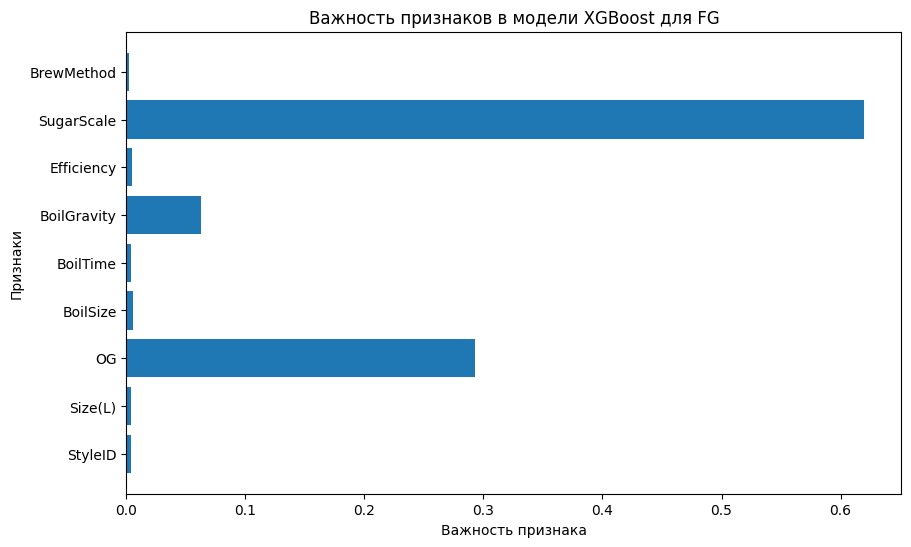

[0]	validation_0-rmse:5.02602
[1]	validation_0-rmse:4.52714
[2]	validation_0-rmse:4.07856
[3]	validation_0-rmse:3.67528
[4]	validation_0-rmse:3.31799
[5]	validation_0-rmse:2.99185
[6]	validation_0-rmse:2.69845
[7]	validation_0-rmse:2.44061
[8]	validation_0-rmse:2.20357
[9]	validation_0-rmse:1.99108
[10]	validation_0-rmse:1.80028
[11]	validation_0-rmse:1.62913
[12]	validation_0-rmse:1.47617
[13]	validation_0-rmse:1.34247
[14]	validation_0-rmse:1.22271
[15]	validation_0-rmse:1.11319
[16]	validation_0-rmse:1.01598
[17]	validation_0-rmse:0.93215
[18]	validation_0-rmse:0.85562
[19]	validation_0-rmse:0.78826
[20]	validation_0-rmse:0.73114
[21]	validation_0-rmse:0.67890
[22]	validation_0-rmse:0.63315
[23]	validation_0-rmse:0.59328
[24]	validation_0-rmse:0.55887
[25]	validation_0-rmse:0.52881
[26]	validation_0-rmse:0.50402
[27]	validation_0-rmse:0.48228
[28]	validation_0-rmse:0.46429
[29]	validation_0-rmse:0.44839
[30]	validation_0-rmse:0.43535
[31]	validation_0-rmse:0.42455
[32]	validation_0-

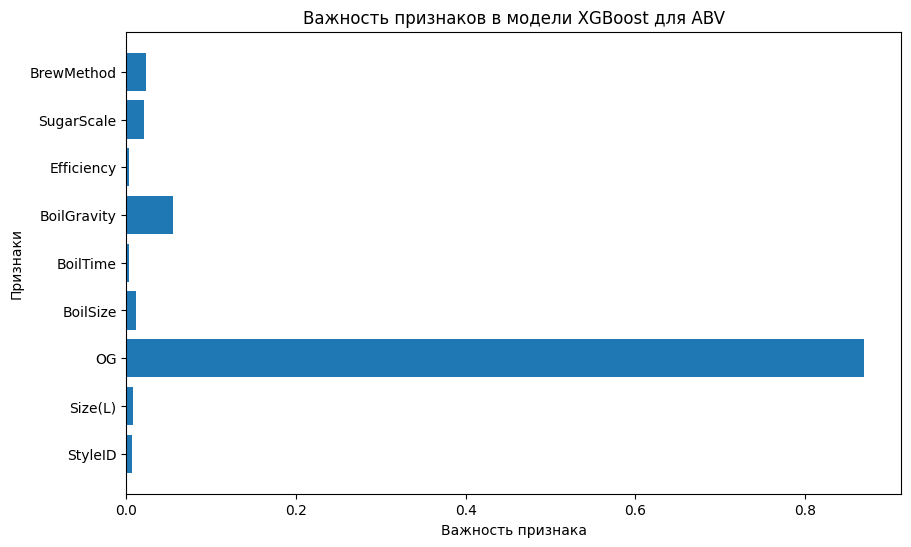

[0]	validation_0-rmse:15.42153
[1]	validation_0-rmse:14.19293
[2]	validation_0-rmse:13.44259
[3]	validation_0-rmse:12.79396
[4]	validation_0-rmse:11.88899
[5]	validation_0-rmse:11.07941
[6]	validation_0-rmse:10.37217
[7]	validation_0-rmse:9.77439
[8]	validation_0-rmse:9.23508
[9]	validation_0-rmse:8.75593
[10]	validation_0-rmse:8.36318
[11]	validation_0-rmse:7.97733
[12]	validation_0-rmse:7.68935
[13]	validation_0-rmse:7.39548
[14]	validation_0-rmse:7.17815
[15]	validation_0-rmse:6.94144
[16]	validation_0-rmse:6.74154
[17]	validation_0-rmse:6.58814
[18]	validation_0-rmse:6.44749
[19]	validation_0-rmse:6.33440
[20]	validation_0-rmse:6.25323
[21]	validation_0-rmse:6.21664
[22]	validation_0-rmse:6.14323
[23]	validation_0-rmse:6.06639
[24]	validation_0-rmse:5.99555
[25]	validation_0-rmse:5.95170
[26]	validation_0-rmse:5.91777
[27]	validation_0-rmse:5.86524
[28]	validation_0-rmse:5.84320
[29]	validation_0-rmse:5.80150
[30]	validation_0-rmse:5.76625
[31]	validation_0-rmse:5.73600
[32]	valida

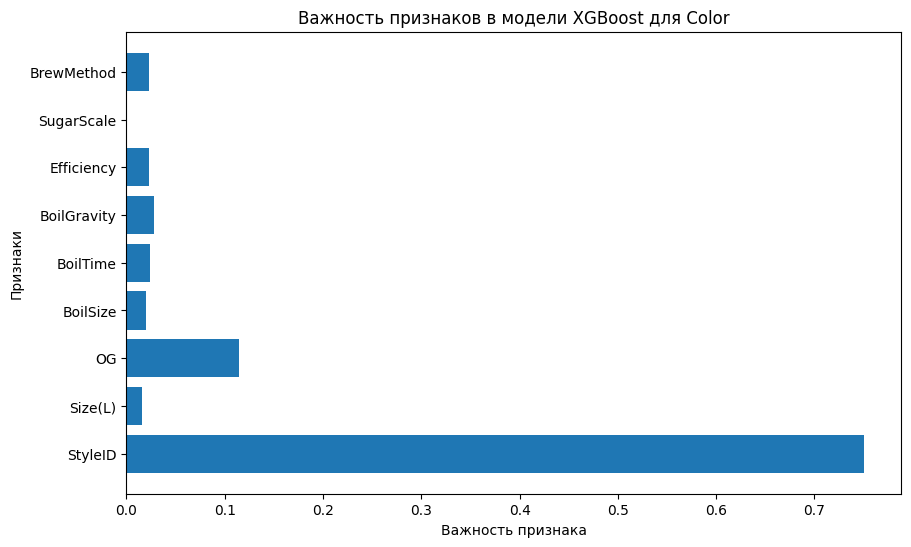

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Целевые переменные
target_variables = ['IBU', 'FG', 'ABV', 'Color']

# Создание и настройка модели градиентного бустинга (XGBoost) для каждой целевой переменной
for target_variable in target_variables:
    # Разделение данных на признаки (X) и целевую переменную (y)
    X = data_df.drop(target_variables, axis=1)
    y = data_df[target_variable]

    # Разделение данных на обучающий и тестовый наборы
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        n_estimators=50,  # Количество деревьев
        learning_rate=0.1,  # Скорость обучения
        max_depth=10,  # Максимальная глубина деревьев
        min_child_weight=1,  # Минимальный вес в узле
        subsample=0.8,  # Доля обучающих данных для каждого дерева
        colsample_bytree=0.8,  # Доля признаков для каждого дерева
        gamma=0,  # Минимальное уменьшение функции потерь
        reg_alpha=0,  # L1 регуляризация
        reg_lambda=1,  # L2 регуляризация
        objective='reg:squarederror',  # Задача оптимизации для регрессии
    )

    # Обучение модели
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=1)

    # Предсказание на тестовом наборе данных
    y_pred = model.predict(X_test)

    # Оценка производительности модели
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Target Variable: {target_variable}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # важность признаков
    feature_importance = model.feature_importances_

    # график важности признаков
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance, align='center')
    plt.yticks(range(len(feature_importance)), X_train.columns)
    plt.xlabel('Важность признака')
    plt.ylabel('Признаки')
    plt.title(f'Важность признаков в модели XGBoost для {target_variable}')
    plt.show()